# **Cryptocurrency Market Analysis: An Automated Data Pipeline**


This notebook demonstrates an end-to-end data pipeline for fetching, processing, storing, and analyzing real-time cryptocurrency data from the CoinMarketCap API. It is structured to showcase best practices in code modularity, security, and data analysis within a Google Colab environment.

**Key Skills Demonstrated:**
API Integration: Securely connecting to and retrieving data from a third-party API.

**Data Processing & Manipulation:** Using the pandas library to clean, transform, and enrich raw JSON data.

**Data Storage:** Saving processed data into a structured CSV format for future use.

**Data Visualization:** Using seaborn and matplotlib to create insightful charts and heatmaps that reveal market trends.

**Code Quality & Best Practices:** Writing clean, documented, and reusable functions with error handling and secure key management.

In [5]:
# --- 1. SETUP: INSTALL AND IMPORT LIBRARIES ---

# Install necessary Python libraries
!pip install requests pandas seaborn matplotlib -q

# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import json
import os
from google.colab import userdata
from typing import List, Dict, Optional, Any

print("Libraries installed and imported successfully.")


Libraries installed and imported successfully.


**Step 2:** Configuration and API Key Management
Securely access the CoinMarketCap API key using Colab's built-in Secrets Manager. This prevents the key from being exposed in the notebook. We also define our constant API endpoint URL.

In [2]:
# --- 2. CONFIGURATION: API KEY AND ENDPOINTS ---

try:
    # Securely fetch the API key from Colab Secrets
    API_KEY = userdata.get('CMC_PRO_API_KEY')
    if not API_KEY:
        raise ValueError("API key not found in Colab Secrets.")
except Exception as e:
    print(f"Error accessing secret: {e}")
    print("Please ensure you have set 'CMC_PRO_API_KEY' in the Secrets (🔑) tab.")
    API_KEY = None # Set to None to prevent further errors

BASE_API_URL = "https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest"

print("Configuration loaded.")

Configuration loaded.


**Step 3:** Modular Functions (The Data Pipeline)
To ensure our code is clean and reusable, we define a series of functions, each with a single responsibility. This is the core of our automated pipeline.

In [3]:
# --- 3. CORE FUNCTIONS: API CLIENT, PROCESSOR, STORAGE ---

def fetch_crypto_data(limit: int = 100, convert: str = 'USD') -> Optional[List[Dict[str, Any]]]:
    """
    Fetches cryptocurrency data from the CoinMarketCap API.

    Args:
        limit: The number of cryptocurrencies to return.
        convert: The currency to convert prices to.

    Returns:
        A list of dictionaries containing crypto data, or None if an error occurs.
    """
    if not API_KEY:
        print("API Key is not available. Cannot fetch data.")
        return None

    parameters = {'start': '1', 'limit': str(limit), 'convert': convert}
    headers = {'Accepts': 'application/json', 'X-CMC_PRO_API_KEY': API_KEY}
    session = requests.Session()
    session.headers.update(headers)

    print(f"Fetching top {limit} cryptocurrencies...")
    try:
        response = session.get(BASE_API_URL, params=parameters)
        response.raise_for_status() # Raises an exception for bad status codes
        data = response.json()
        print("Data fetched successfully.")
        return data.get('data')
    except (requests.exceptions.ConnectionError, requests.exceptions.Timeout, requests.exceptions.TooManyRedirects, requests.exceptions.HTTPError) as e:
        print(f"API request error: {e}")
        return None

def process_data(api_data: Optional[List[Dict[str, Any]]]) -> pd.DataFrame:
    """
    Processes raw API data into a structured and cleaned pandas DataFrame.

    Args:
        api_data: The raw data from the API.

    Returns:
        A processed pandas DataFrame.
    """
    if not api_data:
        print("No data to process.")
        return pd.DataFrame()

    print("Processing raw data into a DataFrame...")
    df = pd.json_normalize(api_data)

    # Add a timestamp for when the data was fetched
    df['timestamp'] = pd.to_datetime('now', utc=True)

    # Select and rename columns for clarity
    columns_to_keep = {
        'name': 'Name',
        'symbol': 'Symbol',
        'cmc_rank': 'Rank',
        'quote.USD.price': 'Price_USD',
        'quote.USD.volume_24h': 'Volume_24h',
        'quote.USD.percent_change_1h': 'Percent_Change_1h',
        'quote.USD.percent_change_24h': 'Percent_Change_24h',
        'quote.USD.percent_change_7d': 'Percent_Change_7d',
        'quote.USD.market_cap': 'Market_Cap_USD',
        'circulating_supply': 'Circulating_Supply',
        'total_supply': 'Total_Supply',
        'max_supply': 'Max_Supply',
        'timestamp': 'Timestamp'
    }
    df = df[columns_to_keep.keys()].rename(columns=columns_to_keep)
    print("Data processing complete.")
    return df

def save_to_csv(df: pd.DataFrame, filename: str = "crypto_market_data.csv") -> None:
    """
    Saves a DataFrame to a CSV file in the Colab environment.

    Args:
        df: The DataFrame to save.
        filename: The name for the output CSV file.
    """
    if df.empty:
        print("DataFrame is empty. Nothing to save.")
        return

    # Colab saves files to the /content/ directory by default
    filepath = f"/content/{filename}"
    df.to_csv(filepath, index=False)
    print(f"Data successfully saved to {filepath}")

**Step 4:** Main Execution Block
This is the main driver of our script. It calls the functions in sequence to execute the data pipeline.

In [6]:
# --- 4. MAIN EXECUTION ---

def main():
    """Main function to run the data pipeline."""
    raw_data = fetch_crypto_data(limit=100)
    processed_df = process_data(raw_data)
    save_to_csv(processed_df)
    return processed_df

# Run the pipeline
df = main()

# Display the first few rows of the final DataFrame
print("\n--- Processed Data Preview ---")
display(df.head())

Fetching top 100 cryptocurrencies...
Data fetched successfully.
Processing raw data into a DataFrame...
Data processing complete.
Data successfully saved to /content/crypto_market_data.csv

--- Processed Data Preview ---


,Name,Symbol,Rank,Price_USD,Volume_24h,Percent_Change_1h,Percent_Change_24h,Percent_Change_7d,Market_Cap_USD,Circulating_Supply,Total_Supply,Max_Supply,Timestamp
0,Bitcoin,BTC,1,108858.997775,4.412279e+10,0.063665,0.726220,2.846284,2.165152e+12,1.988951e+07,1.988951e+07,2.100000e+07,2025-07-08 22:16:37.167075+00:00
1,Ethereum,ETH,2,2604.633916,1.736764e+10,-0.076196,2.683932,8.179245,3.144228e+11,1.207167e+08,1.207167e+08,NaN,2025-07-08 22:16:37.167075+00:00
2,Tether USDt,USDT,3,1.000192,6.209718e+10,0.007697,0.004526,0.000532,1.586891e+11,1.586585e+11,1.608203e+11,NaN,2025-07-08 22:16:37.167075+00:00
3,XRP,XRP,4,2.306528,3.108986e+09,0.067680,1.341142,6.107673,1.362424e+11,5.906819e+10,9.998597e+10,1.000000e+11,2025-07-08 22:16:37.167075+00:00
4,BNB,BNB,5,659.085205,1.516802e+09,0.067795,-0.162299,1.977225,9.285526e+10,1.408851e+08,1.408851e+08,NaN,2025-07-08 22:16:37.167075+00:00


**Step 5:** Data Analysis & Visualization
Now that we have clean, structured data, we can perform analysis and create visualizations to uncover insights. This section demonstrates the ability to not just handle data, but to interpret it.

First, let's get a quick summary of our dataset.

In [7]:
# --- 5.1. DATA ANALYSIS: SUMMARY STATISTICS ---

if not df.empty:
    print("--- Dataframe Info ---")
    df.info()
    print("\n--- Descriptive Statistics ---")
    # Set pandas display option to avoid scientific notation for clarity
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    display(df.describe())
else:
    print("DataFrame is empty, skipping analysis.")


--- Dataframe Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   Name                100 non-null    object             
 1   Symbol              100 non-null    object             
 2   Rank                100 non-null    int64              
 3   Price_USD           100 non-null    float64            
 4   Volume_24h          100 non-null    float64            
 5   Percent_Change_1h   100 non-null    float64            
 6   Percent_Change_24h  100 non-null    float64            
 7   Percent_Change_7d   100 non-null    float64            
 8   Market_Cap_USD      100 non-null    float64            
 9   Circulating_Supply  100 non-null    float64            
 10  Total_Supply        100 non-null    float64            
 11  Max_Supply          47 non-null     float64            
 12  Timestamp     

,Rank,Price_USD,Volume_24h,Percent_Change_1h,Percent_Change_24h,Percent_Change_7d,Market_Cap_USD,Circulating_Supply,Total_Supply,Max_Supply
count,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,47.00
mean,50.50,1208.54,1779964562.01,-0.03,1.95,4.64,33136487743.08,20873729275302.27,21002216446204.82,23401309935668.83
std,29.01,10886.88,7970843218.05,0.35,3.03,8.46,218874970469.54,121419283929741.56,121790558564866.81,104954712363813.42
min,1.00,0.00,1353920.78,-1.58,-4.13,-10.35,570394571.42,246524.00,246524.00,14881364.00
25%,25.75,0.26,35041562.12,-0.20,0.41,0.56,876760249.89,372914432.58,567976036.43,612084381.00
50%,50.50,1.00,95720929.34,0.03,1.79,3.17,1640963639.79,1407410003.18,1636524317.11,2000000000.00
75%,75.25,7.67,226585104.49,0.15,2.99,7.09,5130483914.11,7907452015.09,10549031474.75,36852013300.50
max,100.00,108859.00,62097175938.97,0.97,21.88,61.08,2165152342544.42,986061142857000.00,990000000000000.00,589552695333683.00


**Visualization 1:** Top 10 Cryptocurrencies by Market Capitalization

This chart clearly shows the market leaders and the scale of their dominance compared to others.

/tmp/ipython-input-8-160559228.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipython-input-8-160559228.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{x/1e12:.2f}T' for x in ax.get_xticks()])


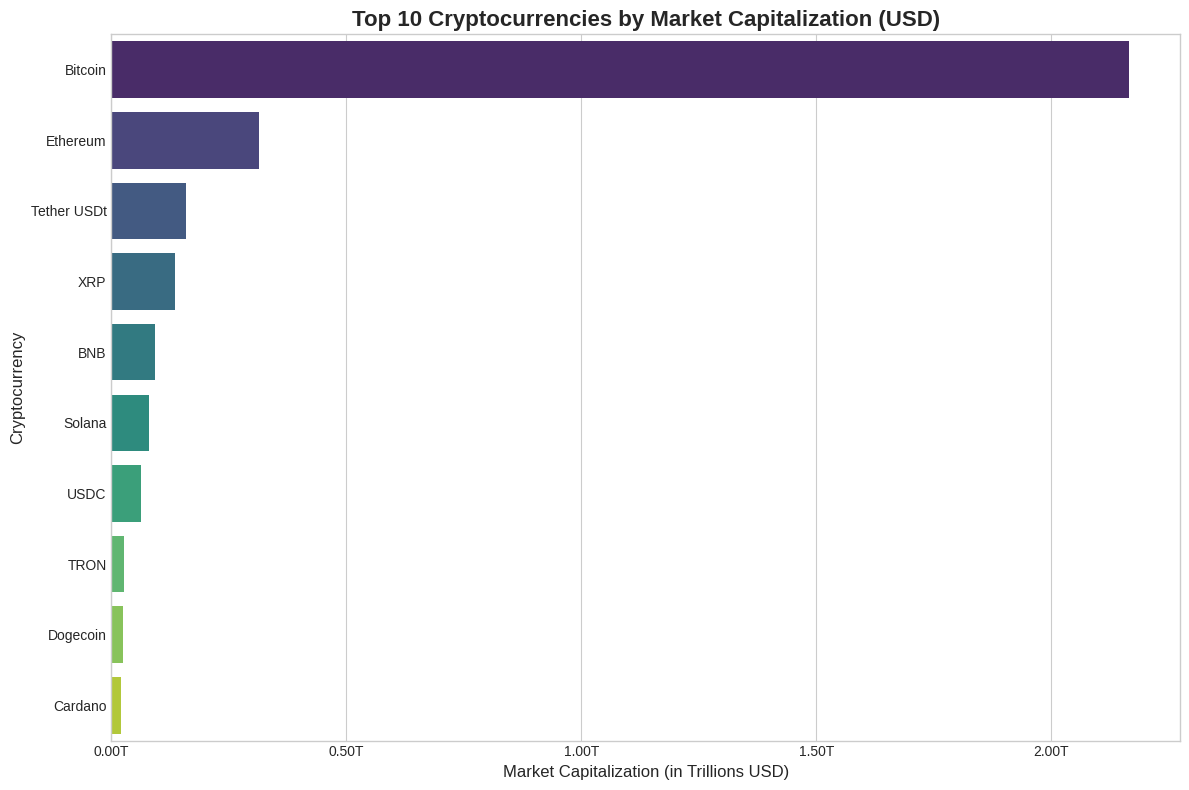

In [8]:
# --- 5.2. VISUALIZATION: TOP 10 BY MARKET CAP ---

if not df.empty:
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 8))

    top_10_market_cap = df.nlargest(10, 'Market_Cap_USD')

    ax = sns.barplot(
        data=top_10_market_cap,
        x='Market_Cap_USD',
        y='Name',
        palette='viridis'
    )

    ax.set_title('Top 10 Cryptocurrencies by Market Capitalization (USD)', fontsize=16, weight='bold')
    ax.set_xlabel('Market Capitalization (in Trillions USD)', fontsize=12)
    ax.set_ylabel('Cryptocurrency', fontsize=12)

    # Format x-axis to be more readable
    ax.set_xticklabels([f'{x/1e12:.2f}T' for x in ax.get_xticks()])

    plt.tight_layout()
    plt.show()
else:
    print("DataFrame is empty, skipping visualization.")


**Visualization 2:** Biggest Movers in the Last 24 Hours

This visualization helps us quickly identify the most volatile assets among the top 100, showing both the biggest gainers and losers. This is useful for identifying short-term trends.

/tmp/ipython-input-10-1463941829.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


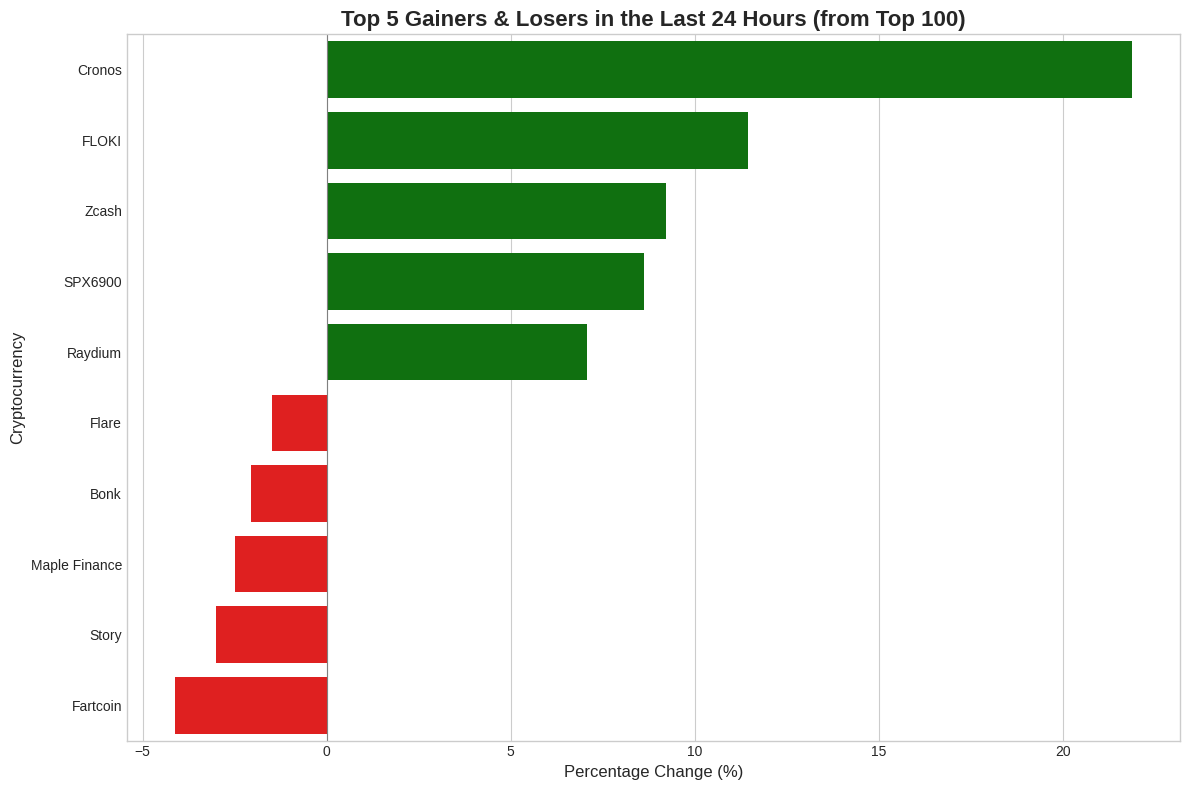

In [10]:
#--- 5.3. VISUALIZATION: 24-HOUR GAINERS AND LOSERS ---

if not df.empty:
    # Sort by 24h change to find biggest movers
    df_sorted = df.sort_values(by='Percent_Change_24h', ascending=False)

    # Get top 5 gainers and top 5 losers
    top_5_gainers = df_sorted.head(5)
    top_5_losers = df_sorted.tail(5)
    movers_df = pd.concat([top_5_gainers, top_5_losers])

    plt.figure(figsize=(12, 8))
    ax = sns.barplot(
        data=movers_df,
        x='Percent_Change_24h',
        y='Name',
        palette= ['green' if x > 0 else 'red' for x in movers_df['Percent_Change_24h']]
    )

    ax.set_title('Top 5 Gainers & Losers in the Last 24 Hours (from Top 100)', fontsize=16, weight='bold')
    ax.set_xlabel('Percentage Change (%)', fontsize=12)
    ax.set_ylabel('Cryptocurrency', fontsize=12)
    ax.axvline(0, color='grey', linewidth=0.8) # Add a line at 0

    plt.tight_layout()
    plt.show()
else:
    print("DataFrame is empty, skipping visualization.")


**Visualization 3:** Correlation Heatmap

A heatmap is an excellent tool to understand the relationships between different numerical features. For example, do cryptocurrencies with higher prices also have higher 24-hour volumes? This map helps us spot such correlations at a glance.

**Interpretation:** Values close to 1.0 (light color) indicate a strong positive correlation. Values close to -1.0 indicate a strong negative correlation. Values near 0 (dark color) indicate little to no correlation.

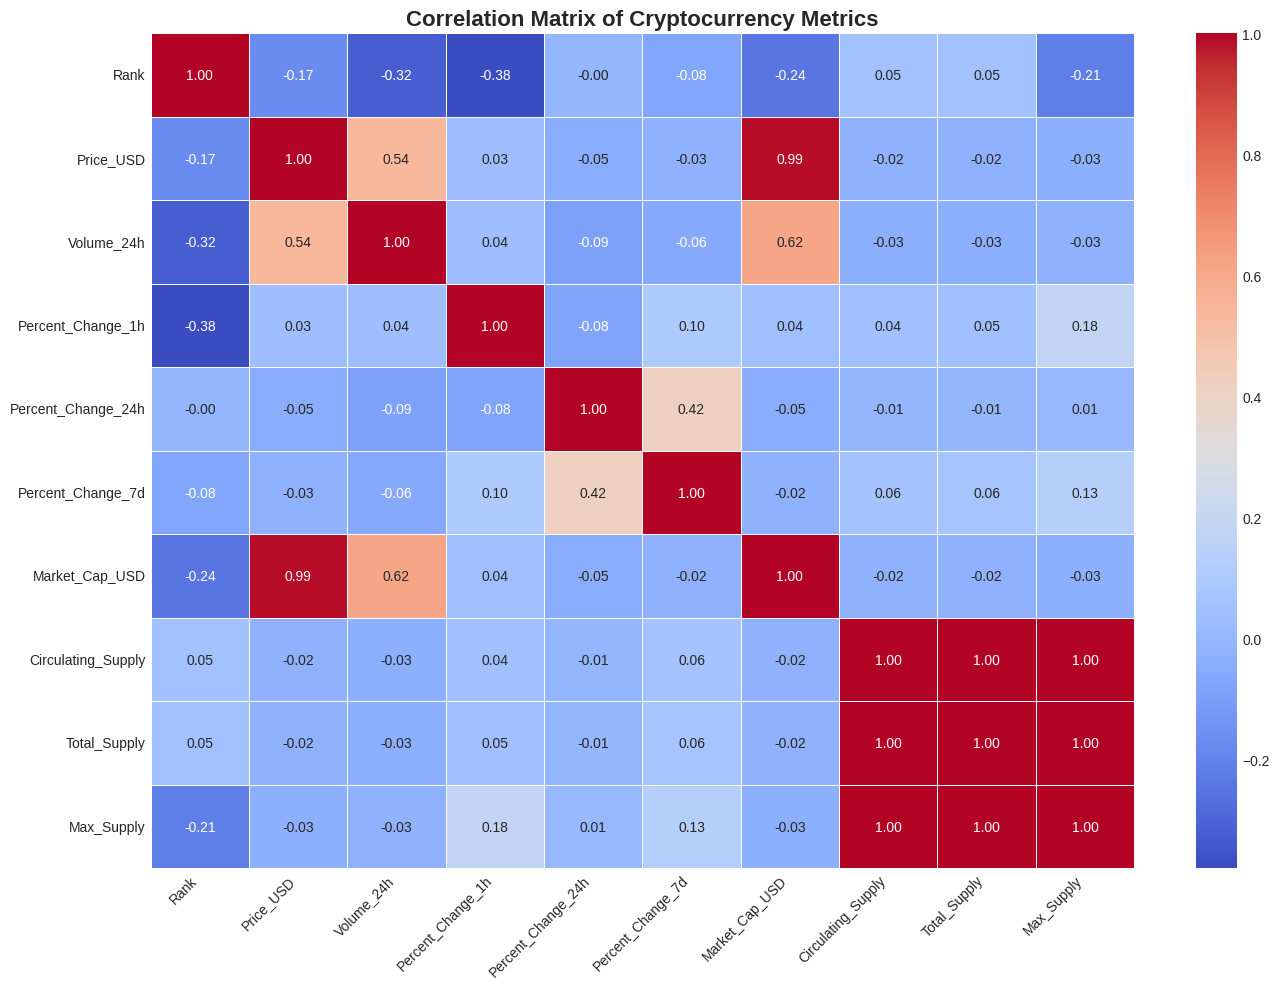

In [11]:
# --- 5.4. VISUALIZATION: CORRELATION HEATMAP ---

if not df.empty:
    # Select only numeric columns for correlation
    numeric_cols = df.select_dtypes(include=['number'])

    plt.figure(figsize=(14, 10))

    # Calculate the correlation matrix
    correlation_matrix = numeric_cols.corr()

    sns.heatmap(
        correlation_matrix,
        annot=True,          # Show the correlation values on the map
        cmap='coolwarm',     # Use a color map that highlights positive/negative
        fmt=".2f",           # Format annotations to two decimal places
        linewidths=.5
    )

    plt.title('Correlation Matrix of Cryptocurrency Metrics', fontsize=16, weight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("DataFrame is empty, skipping visualization.")

#**Conclusion & Potential Next Steps**
This project successfully automates the process of gathering and analyzing cryptocurrency market data. It demonstrates proficiency in Python, data handling with pandas, and creating meaningful visualizations.

**To further enhance this project:**

**Automate Execution:** Deploy this script as a cloud function (e.g., Google Cloud Functions, AWS Lambda) and schedule it to run automatically (e.g., every hour).

**Use a Database:** Instead of saving to a CSV, store the time-series data in a database like PostgreSQL or a time-series database like InfluxDB to track price history.

**Build an Interactive Dashboard:** Use a tool like Dash, Streamlit, or Flask to create a web-based dashboard where users can interact with the data and visualizations.

**Implement Advanced Analytics:** Incorporate statistical analysis or machine learning models to predict future price movements based on the historical data collected.